# Quantamental Trading

In this notebook, we have developed a trading Strategy by using the Fundamental data and some Quant Techniques. Notebook is divided in two parts, Strategy Formulation the Backtesting.

#### Import the relevant Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy.stats
import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import yfinance as yf
from datetime import date
import seaborn as sb
import monthly_returns_heatmap as mrh
import fundamentalanalysis as fa
import seaborn as sb
sb.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

# Strategy Formulation

## Analysis on Group of Companies taking latest Ratios
We will do the inter-company analysis to find the relatively undervalued companies among its peers. We will be using the Z-score method to calculate the scores of the companies and rank them accordingly.

In [2]:
key = '15d3a78098390cc68b5bf8132b213ae7'

In [3]:
"Reference from S&P Value bse Factor indices"

# Z-score testing to compare the company with its peer
def zscore2(data_frame, headline='Z-Score'):
    index = data_frame.index
    z = scipy.stats.zscore(data_frame.astype(float))
    table = pd.DataFrame(z, index=index)
    mean = table.mean(axis=1)
    table2 = pd.DataFrame(mean, index=index)
    condition1 = np.where(table2 == 0, 1, table2)
    condition2 = np.where(condition1 > 0, 1+condition1, 1/(1-condition1))
    final = pd.DataFrame(condition2, index=index)
    final.columns = [headline]
    return final

### Testes

In [4]:
# Using top Nasdaq stocks
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
           'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

# Ratios where the denominator must be high, to derive the value
ratio = ['peRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'debtToAssets', 'netDebtToEBITDA']

f = pd.DataFrame()
for steps in range(len(tickers)):
    p = str(tickers[steps])
    data = fa.key_metrics(
        ticker=p, api_key=key, period='quarter')
    table = data.T[ratio]
    f_1 = table.head(1)
    f = f.append(f_1)

f.index = tickers
# Derive the value metrics out of the algorithm "Inter Company Analysis"
inverse = 1/f

# Inverse matrix consist of the ratios that must be maximised as we have already taken the Reciprocal
inverse

,peRatio,pbRatio,evToSales,debtToEquity,debtToAssets,netDebtToEBITDA
GILD,0.039016,0.202218,0.050765,0.789674,2.333534,0.093188
MU,-0.100126,0.600719,0.046821,3.278813,4.742923,0.085714
AMAT,0.066165,0.148388,0.068857,2.497172,5.141746,1.906542
MSFT,0.03412,0.090751,0.024255,3.216731,6.280163,0.762691
AMD,-0.003547,0.346397,0.034114,19.204354,23.747893,-0.425793
CSCO,0.066499,0.218912,0.075281,5.038718,11.618894,13.154286
QCOM,0.049414,0.142804,0.061655,1.23228,3.025461,0.204849
GOOG,0.045293,0.196275,0.052479,8.958964,12.688129,37.756993
TSLA,0.015304,0.073162,0.036618,17.957399,32.448804,-0.196441
TXN,0.040495,0.09035,0.025115,1.505333,2.885641,0.406267


Function to calculate the Z-score of the above Dataframe. So, that we can have normalized data and can compare the ratios and do the ranking.

In [5]:
# Calling the function and calculating the relative score of each company
z = zscore2(inverse)
z

,Z-Score
GILD,0.753015
MU,0.740383
AMAT,0.964086
MSFT,0.687200
AMD,1.468417
CSCO,1.448593
QCOM,0.801546
GOOG,1.754668
TSLA,1.445974
TXN,0.645975


Comparing the past year performance of each company. We will be using some critical ratios and then will be quantifying so as to convert them into a score.

In [6]:
f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

# WRT to assets and liability
f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

# Ratios where change must reduce Q/Q
g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare']

# WRT to cash, income and book value
columns = ['F-Score-Max', 'F-Score-Min', 'G-Score']


tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
           'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

# F-Score and G-Score analysis to compare the companies with its Past Quarter Performances "Intra Companies Analysis"

M = pd.DataFrame()
for steps in range(len(tickers)):
    p = str(tickers[steps])
    data = fa.key_metrics(
        ticker=p, api_key=key, period="quarter")
    gh = data.T
    gh = gh.iloc[:, 1:]
    gh = gh.loc[::-1]
    gh = gh.loc['2019-12':]
    change = gh.pct_change()
    test = change[f_score_ratio_max].dropna()
    test1 = change[f_score_ratio_min].dropna()
    test2 = change[g_score_ratio_max].dropna()
    g = np.where(test > 0, 1, -1)

    # Conditions to Score the past performance and create a ranking table for every set
    g1 = np.where(test < 0, 1, -1)
    g2 = np.where(test2 > 0, 1, -1)
    array = np.array([g.sum(), g1.sum(), g2.sum()])
    df = pd.DataFrame(array)
    df = df.T
    M = M.append(df)
    
M.index = tickers
M.columns = columns

# Now, as we already have the scores, we take the z-score of the final DataFrame,
# in order to compare the scores with each other

# Comparing the Score table along with its peers
ZS = scipy.stats.zscore(M)
ZS = pd.DataFrame(ZS)
ZS.index = M.index
ZS.columns = M.columns
v = pd.concat([ZS, z], axis=1)
Score_table = pd.DataFrame({"Score": v.sum(axis=1)})
y = Score_table.sort_values(by='Score', ascending=False)

# Final DataFrame having the Score of each company
y

,Score
GOOG,2.566864
TSLA,2.407785
CSCO,1.961559
ATVI,1.892584
TXN,1.757400
MSFT,1.649011
AMAT,1.477052
PCAR,1.199975
AMD,1.083693
QCOM,0.865666


Above Dataframe has final score and it represents the relatively undervalued companies, which are also fundamentally strong.

# Backtesting the strategy 
Selecting the companies at start of the year and then taking the positions in them for the year long and 
rebalancing the companies at start of next year.

In [7]:
tickers = ["GILD", 'MU', 'AMAT', 'MSFT', 'AMD', 'CSCO', 'QCOM',
       'GOOG', 'TSLA', 'TXN', 'INTC', 'ATVI', 'PEP', 'PCAR']

In [8]:
# WRT to cash, income and book value
columns = ['F-Score-Max', 'F-Score-Min', 'G-Score']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

# Ratios to derive out the value factor
Full_table = pd.DataFrame()
year = ['2017','2018', '2019', '2020']

for steps1 in range(len(year)):
    for steps2 in range(len(tickers)):
        p = str(tickers[steps2])
        data = fa.key_metrics(
            ticker=p, api_key=key, period='annual')
        table = data.T[ratio]
        table = table.loc[year[steps1]]
        Full_table = Full_table.append(table)

Full_table

,peRatio,priceToSalesRatio,pbRatio,evToSales,debtToEquity,evToFreeCashFlow,debtToAssets,netDebtToEBITDA
2017,20.231953,3.586528,4.580446,4.580667,1.640837,10.575476,0.477242,1.628946
2017,6.841291,1.713184,1.869681,2.010694,0.599055,11.951252,0.315684,0.625556
2017,17.466715,4.126071,6.415734,4.146296,0.567333,18.466513,0.273135,0.067804
2017,25.180710,5.935873,7.375360,6.808925,1.190624,19.518860,0.357524,2.299657
2017,227.594419,1.836472,16.017283,1.875879,2.283142,-222.145778,0.394068,0.603448
2017,16.434093,3.289557,2.387698,3.748030,0.509805,13.934650,0.259725,1.426008
2017,30.917575,3.420337,2.479761,2.831041,0.712060,15.764861,0.334316,-2.639871
2017,57.274197,6.541932,4.755386,6.481078,0.026026,30.052281,0.020117,-0.175071
2017,-26.312244,4.388973,12.179818,5.132932,2.859395,-14.571886,0.422816,-85.958868
2017,28.109734,6.917989,10.012580,7.079810,0.394408,22.690883,0.231096,0.342821


In [9]:
pd.__version__

'1.3.5'

In [10]:
#!pip uninstall pandas --yes
#!pip install pandas==1.3.5

In [11]:
rank = pd.DataFrame()

for steps in range(len(year)):
    y = Full_table.loc[year[steps]]
    t_inv = 1/y
    bv = zscore2(t_inv)
    bv = bv.T
    bv.index = [year[steps]]
    bv.columns = tickers
    
    rank = rank.append(bv)

In [12]:
name = pd.DataFrame(tickers)
concated = pd.concat([name]*len(year), axis=0)
concated.index = Full_table.index
concated.columns = ['Company']

lista_z_score = []
for i in year:
    lista_z_score += list(rank.loc[i])

lista_z_score = pd.DataFrame(lista_z_score,index=Full_table.index,columns=['Z-Score'])
rank = pd.concat([concated, lista_z_score], axis=1)

rank.head()

,Company,Z-Score
2017,GILD,1.009932
2017,MU,2.056281
2017,AMAT,1.244755
2017,MSFT,0.732541
2017,AMD,0.903451


Now doing the Intra-Company analysis, comparing the past performances of the companies to derive out fundamentally strong companies.

In [13]:
f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

# WRT to assets and liability
f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

# Ratios where change must reduce Q/Q
g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']


percent_fscore_max = pd.DataFrame()
percent_fscore_min = pd.DataFrame()
percent_gscore_max = pd.DataFrame()

for steps in range(len(tickers)):
    # Fscore-Max analysis
    p = str(tickers[steps])
    data3 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose = data3.T[f_score_ratio_max].fillna(0)
    reverse = tranpose.loc[::-1]
    change = reverse.pct_change()
    change = change.assign(Company=p)
    percent_fscore_max = percent_fscore_max.append(change)

    # Fscore-Min analysis
    data4 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose1 = data4.T[f_score_ratio_min].fillna(0)
    reverse1 = tranpose1.loc[::-1]
    change1 = reverse1.pct_change()
    change1 = change1.assign(Company=p)
    percent_fscore_min = percent_fscore_min.append(change1)

    # Gscore-Max analysis
    data5 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose2 = data5.T[g_score_ratio_max].fillna(0)
    reverse2 = tranpose2.loc[::-1]
    change2 = reverse2.pct_change()
    change2 = change2.assign(Company=p)
    percent_gscore_max = percent_gscore_max.append(change2)
    
# Condition to quantify the performance
condition = np.where(percent_fscore_max.iloc[:, :-1] > 0, 1, -1)
condition = pd.DataFrame(condition)
condition.index = percent_fscore_max.index
condition.columns = percent_fscore_max.columns[:-1]
condition
sum_score = condition.sum(axis=1)
sum_score = pd.DataFrame(sum_score)
sum_score = pd.concat([sum_score, percent_fscore_max['Company']], axis=1)
sum_score.columns = ['F-Score-Max','Company']
sum_score

# Condition to quantify the performance
condition2 = np.where(percent_fscore_min.iloc[:, :-1] < 0, 1, -1)
condition2 = pd.DataFrame(condition2)
condition2.index = percent_fscore_min.index
condition2.columns = percent_fscore_min.columns[:-1]
condition2
sum_score2 = condition2.sum(axis=1)
sum_score2 = pd.DataFrame(sum_score2)
sum_score2 = pd.concat([sum_score2, percent_fscore_min['Company']], axis=1)
sum_score2.columns = ['F-Score-Min','Company']
sum_score2

# Condition to quantify the performance
condition3 = np.where(percent_gscore_max.iloc[:, :-1] > 0, 1, -1)
condition3 = pd.DataFrame(condition3)
condition3.index = percent_gscore_max.index
condition3.columns = percent_gscore_max.columns[:-1]
sum_score3 = condition3.sum(axis=1)
sum_score3 = pd.DataFrame(sum_score3)
sum_score3 = pd.concat([sum_score3, percent_gscore_max['Company']], axis=1)
sum_score3.columns = ['G-Score-Max','Company']

In [14]:
Final_yr_wise = pd.concat([sum_score['F-Score-Max'], sum_score2['F-Score-Min'], sum_score3['G-Score-Max'],sum_score['Company']], axis=1)
Final_yr_wise.head(4)

,F-Score-Max,F-Score-Min,G-Score-Max,Company
1991,-4,-3,-6,GILD
1992,-2,-1,4,GILD
1993,0,-3,-2,GILD
1994,2,-1,2,GILD


In [15]:
rank.loc[year[0:]].head()
Final_yr_wise.loc[year[0:]].head()

,F-Score-Max,F-Score-Min,G-Score-Max,Company
2017,-2,1,2,GILD
2017,-2,-1,0,MU
2017,2,-3,4,AMAT
2017,4,-1,4,MSFT
2017,-4,1,-2,AMD


In [16]:
company = pd.DataFrame(Final_yr_wise['Company'])

vc = zscore2(Final_yr_wise[Final_yr_wise.columns[:-1]], headline='Cumulative-F&G-Score')
vc['Company'] = company

rank = rank.loc[year[0]:]

# Now Joing the two Dataframes and getting a cumulative score of each company for each year
vc_new = vc.reset_index()
vc_new['key'] = vc_new['index']+str('_')+vc_new['Company']
vc_new.head(3)
rank_new = rank.reset_index()
rank_new['key'] = rank_new['index']+str('_')+rank_new['Company']
df = vc_new.merge(rank_new, on='key')
df = df.drop(labels=['Company_x', 'key', 'index_y'], axis=1)
df.index = df['index_x']
dataframe = df.drop(labels='index_x', axis=1)
dataframe['Cumulative-Score'] = dataframe['Cumulative-F&G-Score'] + \
    dataframe['Z-Score'].values
dataframe_final = dataframe.drop(
    labels=['Cumulative-F&G-Score', 'Z-Score'], axis=1)
dataframe_final.head(4)

,Company_y,Cumulative-Score
index_x,,
2017,GILD,2.266047
2018,GILD,3.538244
2019,GILD,2.655932
2020,GILD,1.327655


In [17]:
stock = yf.download(tickers=tickers, start='2017-01-01',
                    end='2020-12-31', interval='1mo')[['Close']]

[*********************100%***********************]  14 of 14 completed


In [18]:
stock.index = pd.to_datetime(stock.index)

In [19]:
stock = (stock.T.drop_duplicates().T).dropna()
stock.columns = tickers
returns = stock.pct_change().dropna()

Taking the positions in the top 6 Companies, with equally weighted rule.

In [20]:
df = pd.DataFrame()
df2 = pd.DataFrame()

for steps in range(len(year)):
    sorted_table = (dataframe_final.loc[year[steps]]).sort_values(
        by='Cumulative-Score', ascending=False)
    selection = sorted_table[['Company_y']].head(6)
    array = np.array(selection['Company_y'])
    frame1 = pd.DataFrame(array)
    returns_selection = returns.loc[year[steps]]
    selected_returns = returns_selection[array]

    # Making the portfolio with equal weights among its components
    weight = np.repeat(1/6, 6)
    series = (selected_returns*weight).sum(axis=1)
    frame = pd.DataFrame(series)
    df = df.append(frame)
    df2 = df2.append(frame1)

In [21]:
comp_index = np.repeat(year, 6)
df2.index = comp_index
df2.columns = ['Companies-Invested']

In [22]:
list_comp = pd.DataFrame()
for steps in range(len(year)):
    f = df2.loc[year[steps]]['Companies-Invested'].T
    mk = np.array(f)
    l = pd.DataFrame(mk).T
    list_comp = list_comp.append(l)

list_comp.index = year
list_comp

,0,1,2,3,4,5
2017,PCAR,MU,MSFT,AMAT,GILD,GOOG
2018,GILD,MU,INTC,AMD,PCAR,GOOG
2019,ATVI,MU,MSFT,PCAR,GILD,GOOG
2020,AMAT,INTC,AMD,CSCO,MU,PCAR


Following DataFrame shows the list of the companies in which we Invested Year-Wise.

Weights- Equally Weighted.

In [23]:
df.columns = ['Returns']
df.index = pd.to_datetime(df.index).to_period('M')

Downloading the Benchmark 'NASDAQ' and Comparing the performance with it.

In [24]:
benchmark = yf.download(tickers='NDAQ', start='2017-01-01',
                        end='2020-12-31', interval='1mo')[['Close']]

[*********************100%***********************]  1 of 1 completed


In [25]:
benchmark = (benchmark.T.drop_duplicates().T).dropna()

In [26]:
benchmark.index = pd.to_datetime(benchmark.index).to_period('M')

In [27]:
benchmark_returns = benchmark.pct_change().dropna()

In [28]:
frame_final = pd.concat([df, benchmark_returns], axis=1)
frame_final.columns = ['strategy', 'nasdaq']
frame_final

,strategy,nasdaq
Date,,
2017-02,0.115141,0.008081
2017-03,0.042452,-0.023344
2017-04,0.006053,-0.008351
2017-05,0.013280,-0.017715
2017-06,-0.014882,0.056763
2017-07,0.058938,0.040285
2017-08,0.017496,0.013581
2017-09,0.040320,0.029053
2017-10,0.028540,-0.063427


## Comparing the Returns of the Strategy with the NASDAQ
Import `teersheet` module to get full performance metric.

In [29]:
import tearsheet as ts

Performance Metrics: Quantemantal Strategy
╒═════════════════════╤════════════╤══════════╕
│                     │ strategy   │ nasdaq   │
╞═════════════════════╪════════════╪══════════╡
│ Start-Date          │ 2017-02    │ 2017-02  │
├─────────────────────┼────────────┼──────────┤
│ End-Date            │ 2020-12    │ 2020-12  │
├─────────────────────┼────────────┼──────────┤
│ Total-Months-Tested │ 47         │ 47       │
├─────────────────────┼────────────┼──────────┤
│ Monthly-Returns     │ 2.48       │ 1.35     │
├─────────────────────┼────────────┼──────────┤
│ CAGR                │ 34.21      │ 17.52    │
├─────────────────────┼────────────┼──────────┤
│ Absolute-Return     │ 183.91     │ 86.67    │
├─────────────────────┼────────────┼──────────┤
│ Monthly-Volatility  │ 6.22       │ 5.66     │
├─────────────────────┼────────────┼──────────┤
│ Annual-Volatility   │ 21.54      │ 19.59    │
├─────────────────────┼────────────┼──────────┤
│ Sharpe-Ratio        │ 1.53       │ 0.83    

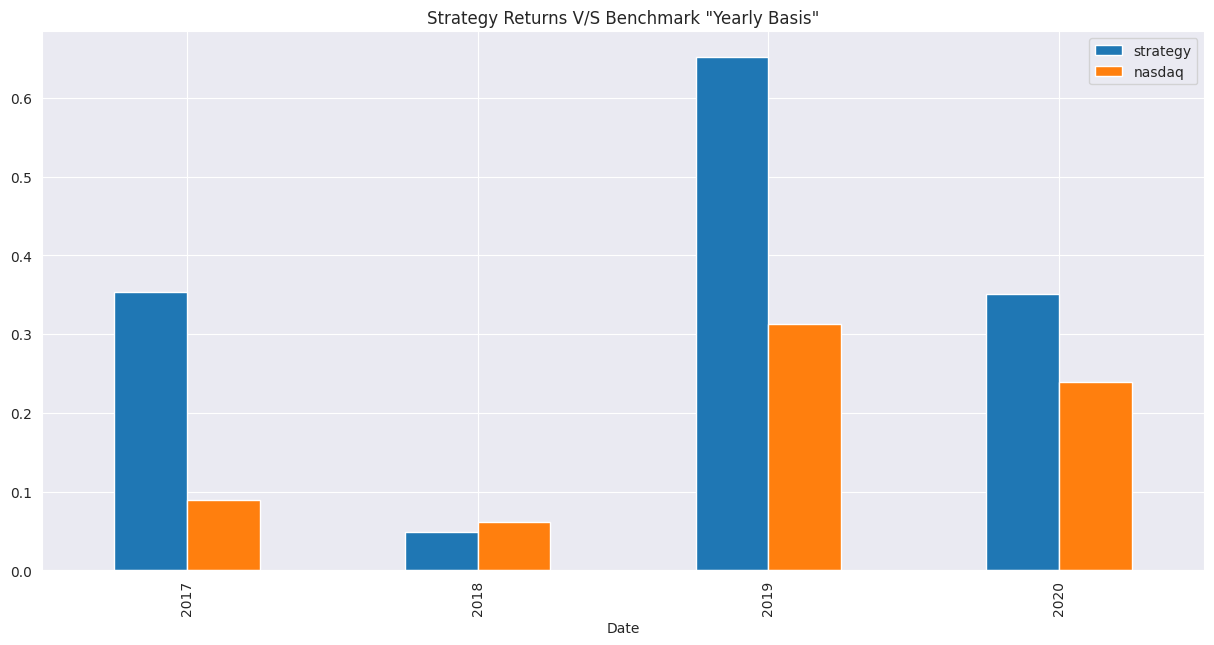

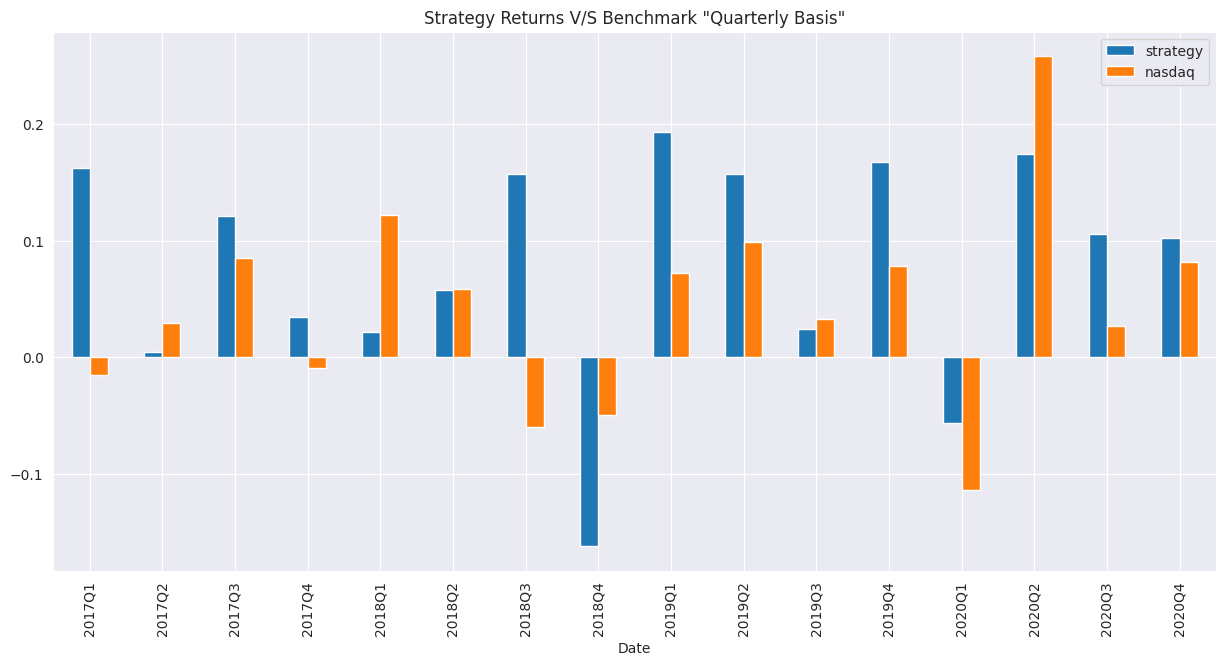

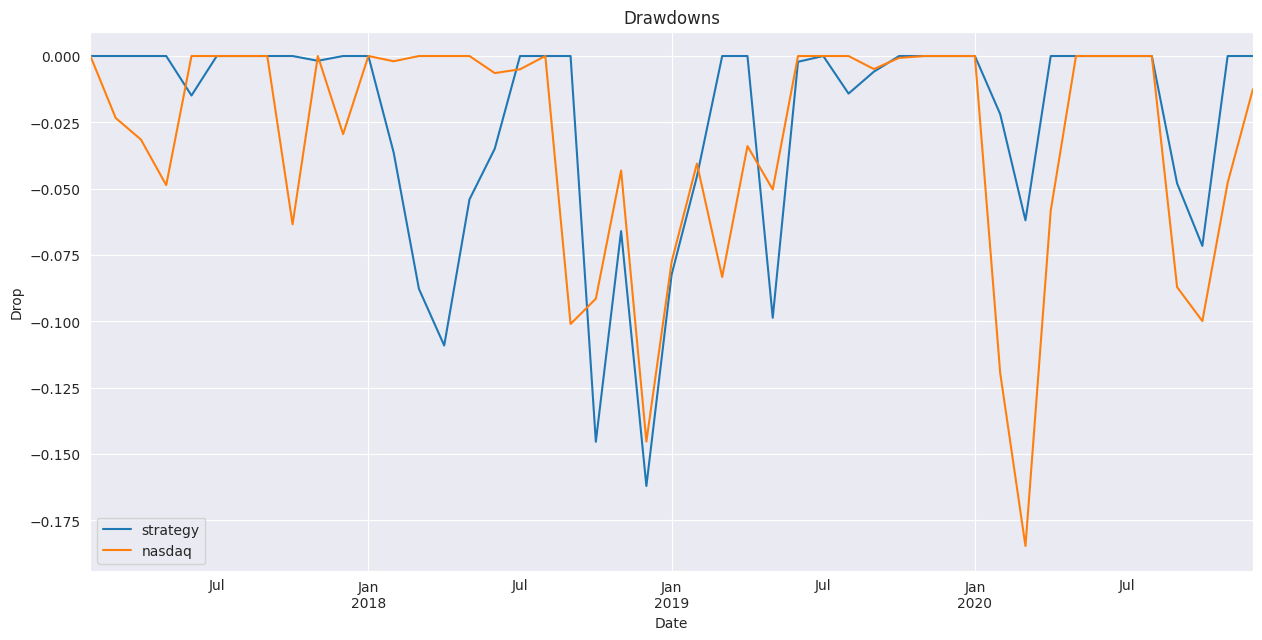

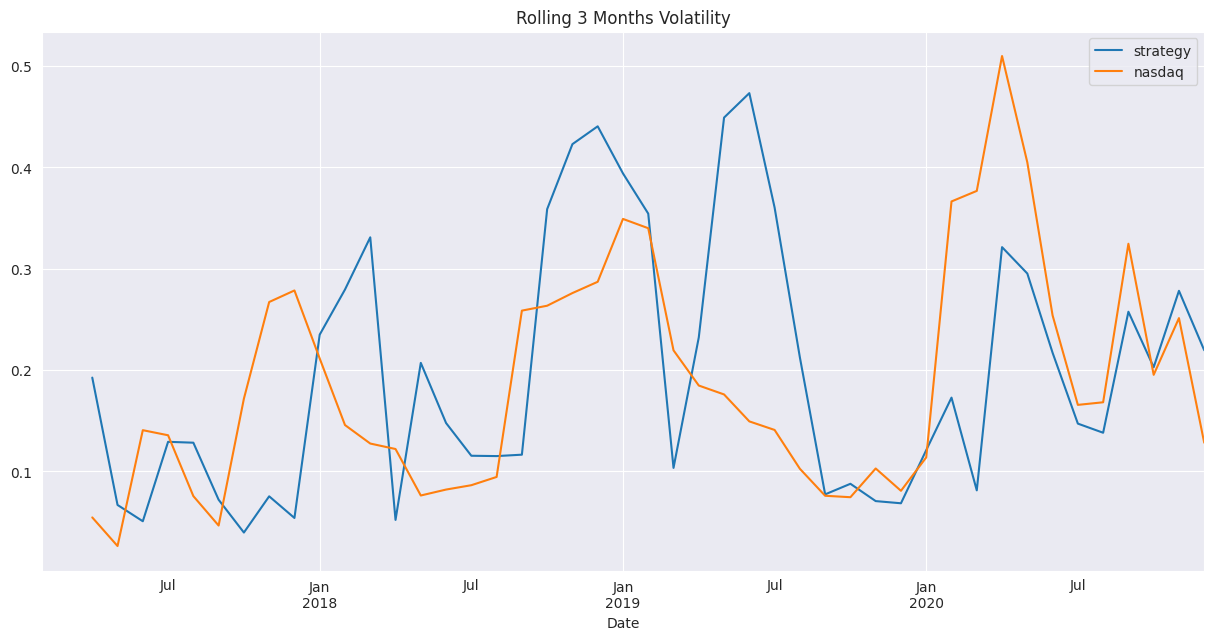

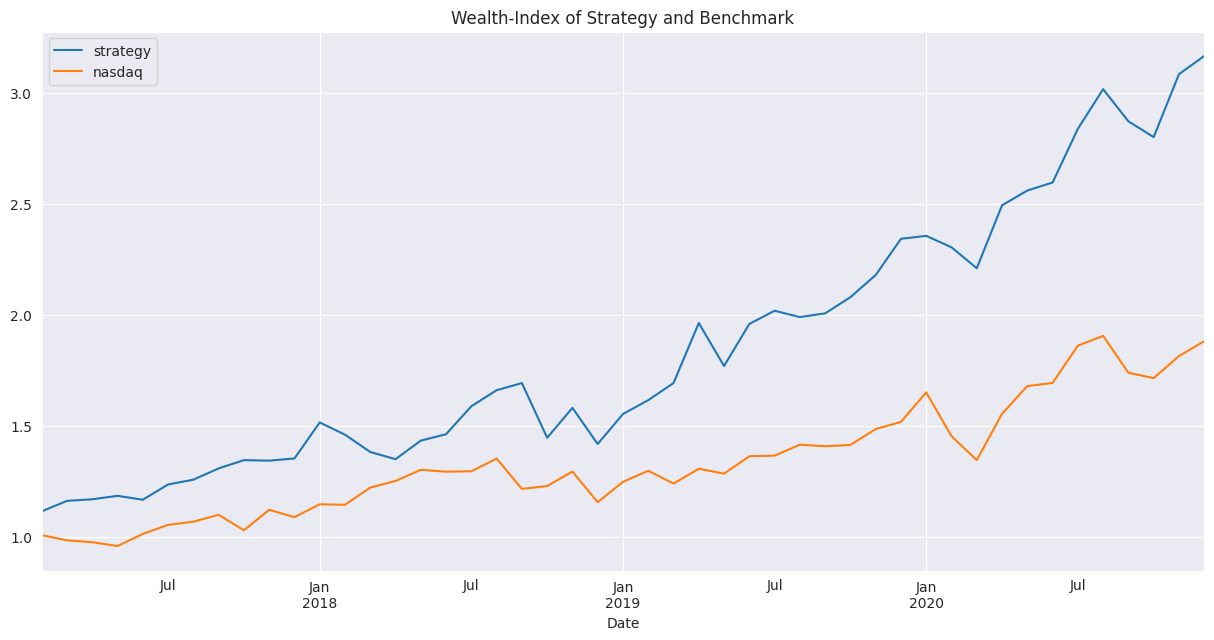

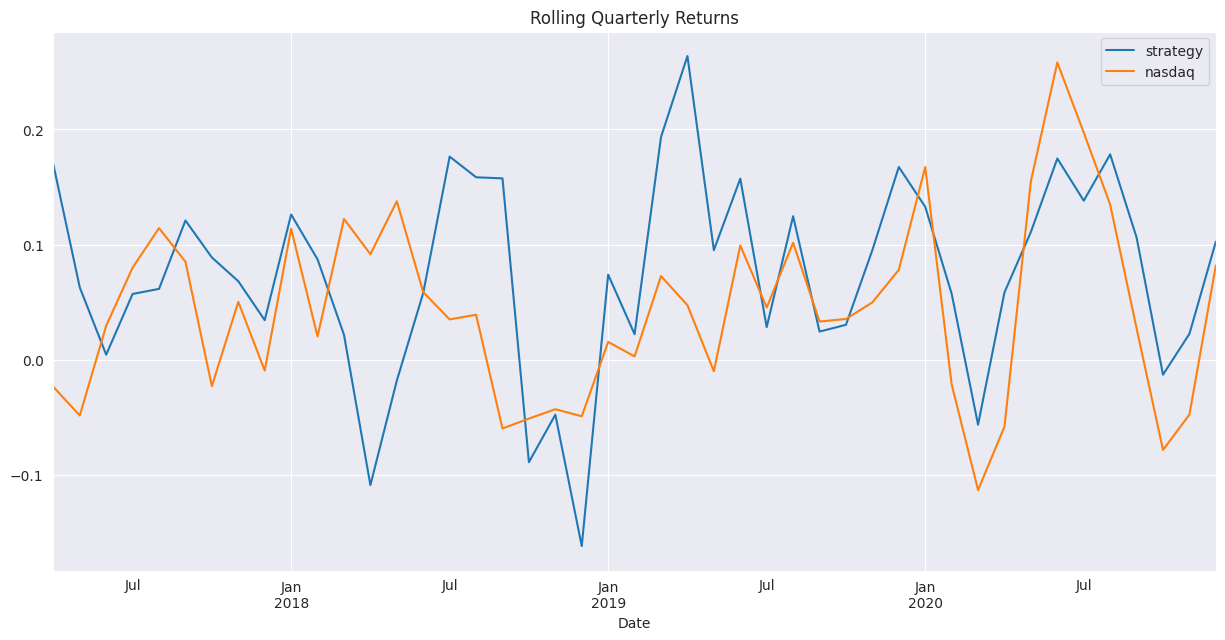

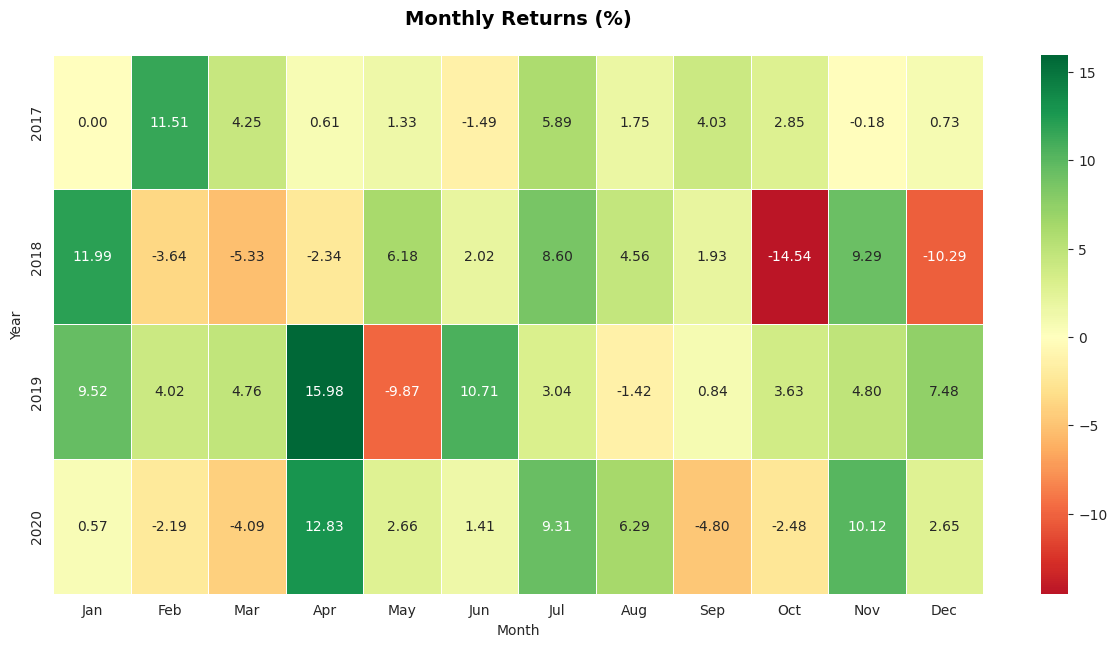

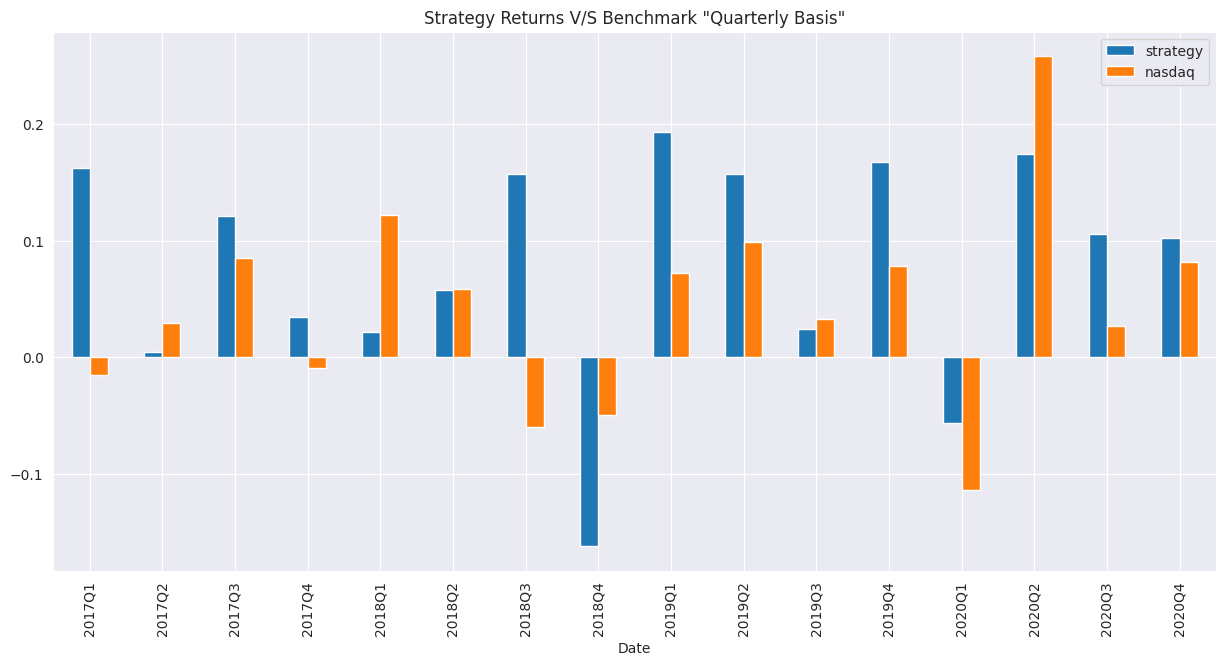

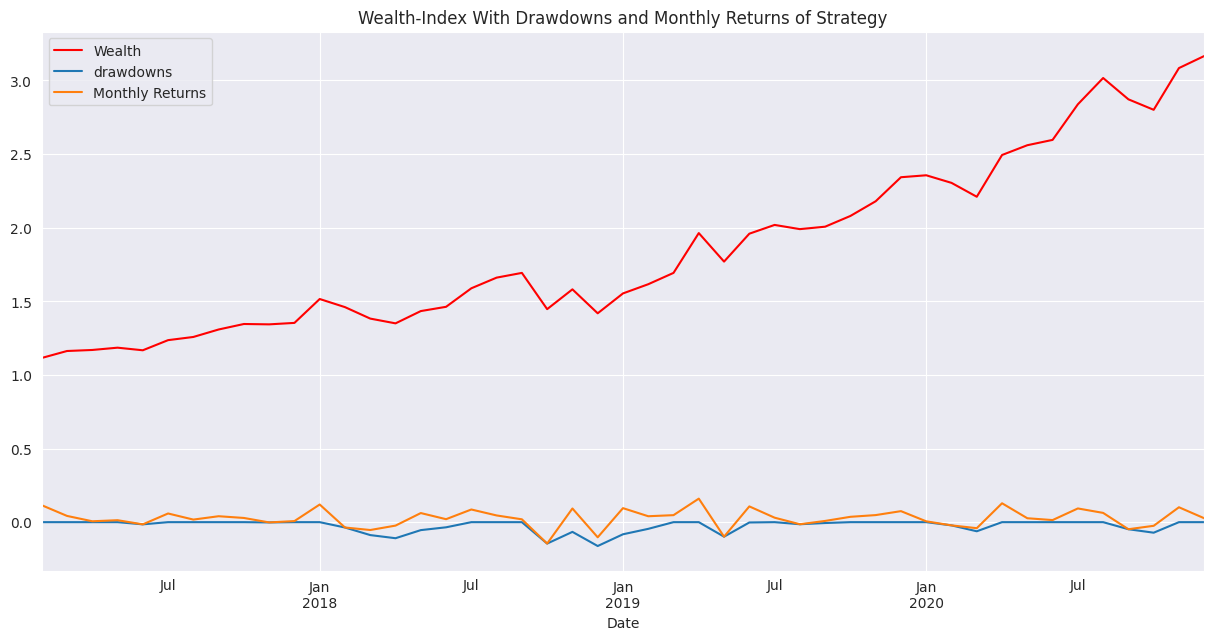

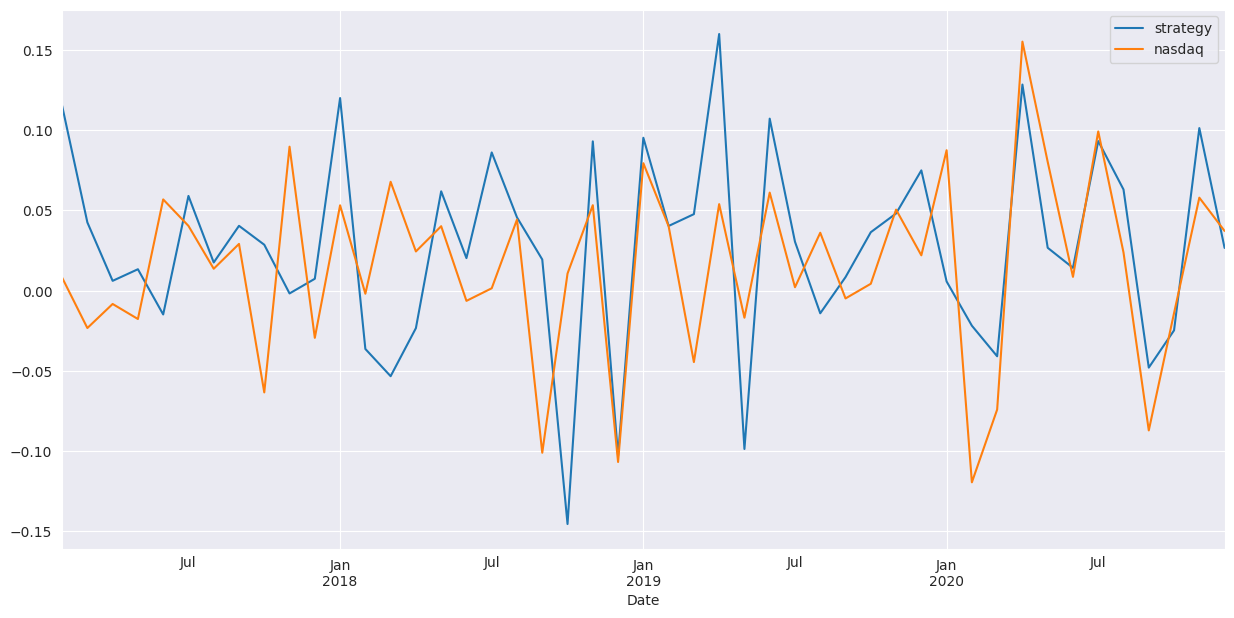

In [30]:
tear = ts.tear_sheet(frame_final, headline='Quantemantal Strategy')

# Replicando estudo sem nenhuma alteração para as 20 principais ações do Ibovespa 

In [31]:
tickers = ["VALE3.SA","PETR4.SA","ITUB4.SA","BBDC4.SA","B3SA3.SA"
           ,"ELET3.SA","BBAS3.SA","ABEV3.SA","RENT3.SA","ITSA4.SA",
           "WEGE3.SA","CSAN3.SA","LREN3.SA","EQTL3.SA","RADL3.SA",
           "SUZB3.SA","PRIO3.SA","GGBR4.SA","JBSS3.SA","BBDC3.SA"]

len(tickers)

20

In [32]:
# WRT to cash, income and book value
columns = ['F-Score-Max', 'F-Score-Min', 'G-Score']

ratio = ['peRatio', 'priceToSalesRatio', 'pbRatio', 'evToSales',
         'debtToEquity', 'evToFreeCashFlow', 'debtToAssets', 'netDebtToEBITDA']

# Ratios to derive out the value factor
Full_table = pd.DataFrame()
year = ['2011','2012','2013','2014','2015','2016','2017','2018', '2019', '2020']

for steps1 in range(len(year)):
    for steps2 in range(len(tickers)):
        p = str(tickers[steps2])
        data = fa.key_metrics(
            ticker=p, api_key=key, period='annual')
        table = data.T[ratio]
        table = table.loc[year[steps1]]
        Full_table = Full_table.append(table)

Full_table

,peRatio,priceToSalesRatio,pbRatio,evToSales,debtToEquity,evToFreeCashFlow,debtToAssets,netDebtToEBITDA
2011,4.849135,1.881208,1.427941,2.236777,0.315332,15.668858,0.190370,0.603528
2011,7.480568,1.031536,0.855995,1.469256,0.471610,-64.457760,0.259626,1.645625
2011,11.126058,2.072692,2.082083,2.190671,1.965148,-14.380404,0.177605,0.116460
2011,5.349839,1.129452,0.991288,0.643243,1.158981,-0.795088,0.094953,-0.397874
2011,18.232143,10.036799,0.993552,10.036799,0.000000,13.007715,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2020,-7.371343,2.592999,10.921654,4.932327,10.798336,18.262323,0.767103,4.892366
2020,20.979705,4.988432,3.015127,5.895143,0.804916,14.771019,0.373308,1.369121
2020,17.417276,0.949303,1.347797,1.263752,0.596063,12.029619,0.291410,1.647307
2020,13.661434,0.232489,1.565817,0.426163,1.794925,6.488485,0.439624,2.469496


In [33]:
rank = pd.DataFrame()

for steps in range(len(year)):
    y = Full_table.loc[year[steps]]
    t_inv = 1/y
    bv = zscore2(t_inv)
    bv = bv.T
    bv.index = [year[steps]]
    bv.columns = tickers
    
    rank = rank.append(bv)

In [34]:
name = pd.DataFrame(tickers)
concated = pd.concat([name]*len(year), axis=0)
concated.index = Full_table.index
concated.columns = ['Company']

lista_z_score = []
for i in year:
    lista_z_score += list(rank.loc[i])

lista_z_score = pd.DataFrame(lista_z_score,index=Full_table.index,columns=['Z-Score'])
rank = pd.concat([concated, lista_z_score], axis=1)

rank

,Company,Z-Score
2011,VALE3.SA,1.198905
2011,PETR4.SA,1.282752
2011,ITUB4.SA,0.797955
2011,BBDC4.SA,1.099543
2011,B3SA3.SA,0.751432
...,...,...
2020,SUZB3.SA,0.525550
2020,PRIO3.SA,0.767735
2020,GGBR4.SA,1.164545
2020,JBSS3.SA,1.979066


Now doing the Intra-Company analysis, comparing the past performances of the companies to derive out fundamentally strong companies.

In [35]:
f_score_ratio_max = ['roe', 'returnOnTangibleAssets',
                     'researchAndDdevelopementToRevenue', 'currentRatio']

# WRT to assets and liability
f_score_ratio_min = ['averagePayables',
                     'daysOfInventoryOnHand', 'interestDebtPerShare']

# Ratios where change must reduce Q/Q
g_score_ratio_max = ['netIncomePerShare', 'freeCashFlowPerShare',
                     "shareholdersEquityPerShare", 'cashPerShare', 'bookValuePerShare', 'incomeQuality']


percent_fscore_max = pd.DataFrame()
percent_fscore_min = pd.DataFrame()
percent_gscore_max = pd.DataFrame()

for steps in range(len(tickers)):
    # Fscore-Max analysis
    p = str(tickers[steps])
    data3 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose = data3.T[f_score_ratio_max].fillna(0)
    reverse = tranpose.loc[::-1]
    change = reverse.pct_change()
    change = change.assign(Company=p)
    percent_fscore_max = percent_fscore_max.append(change)

    # Fscore-Min analysis
    data4 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose1 = data4.T[f_score_ratio_min].fillna(0)
    reverse1 = tranpose1.loc[::-1]
    change1 = reverse1.pct_change()
    change1 = change1.assign(Company=p)
    percent_fscore_min = percent_fscore_min.append(change1)

    # Gscore-Max analysis
    data5 = fa.key_metrics(
        ticker=p, api_key=key, period='annual')
    tranpose2 = data5.T[g_score_ratio_max].fillna(0)
    reverse2 = tranpose2.loc[::-1]
    change2 = reverse2.pct_change()
    change2 = change2.assign(Company=p)
    percent_gscore_max = percent_gscore_max.append(change2)
    
# Condition to quantify the performance
condition = np.where(percent_fscore_max.iloc[:, :-1] > 0, 1, -1)
condition = pd.DataFrame(condition)
condition.index = percent_fscore_max.index
condition.columns = percent_fscore_max.columns[:-1]
condition
sum_score = condition.sum(axis=1)
sum_score = pd.DataFrame(sum_score)
sum_score = pd.concat([sum_score, percent_fscore_max['Company']], axis=1)
sum_score.columns = ['F-Score-Max','Company']
sum_score

# Condition to quantify the performance
condition2 = np.where(percent_fscore_min.iloc[:, :-1] < 0, 1, -1)
condition2 = pd.DataFrame(condition2)
condition2.index = percent_fscore_min.index
condition2.columns = percent_fscore_min.columns[:-1]
condition2
sum_score2 = condition2.sum(axis=1)
sum_score2 = pd.DataFrame(sum_score2)
sum_score2 = pd.concat([sum_score2, percent_fscore_min['Company']], axis=1)
sum_score2.columns = ['F-Score-Min','Company']
sum_score2

# Condition to quantify the performance
condition3 = np.where(percent_gscore_max.iloc[:, :-1] > 0, 1, -1)
condition3 = pd.DataFrame(condition3)
condition3.index = percent_gscore_max.index
condition3.columns = percent_gscore_max.columns[:-1]
sum_score3 = condition3.sum(axis=1)
sum_score3 = pd.DataFrame(sum_score3)
sum_score3 = pd.concat([sum_score3, percent_gscore_max['Company']], axis=1)
sum_score3.columns = ['G-Score-Max','Company']

In [36]:
Final_yr_wise = pd.concat([sum_score['F-Score-Max'], sum_score2['F-Score-Min'], sum_score3['G-Score-Max'],sum_score['Company']], axis=1)

print(rank.loc[year[0:]].head())
Final_yr_wise.loc[year[0:]].head()

       Company   Z-Score
2011  VALE3.SA  1.198905
2011  PETR4.SA  1.282752
2011  ITUB4.SA  0.797955
2011  BBDC4.SA  1.099543
2011  B3SA3.SA  0.751432


,F-Score-Max,F-Score-Min,G-Score-Max,Company
2011,4,1,2,VALE3.SA
2011,2,1,-4,PETR4.SA
2011,2,1,-4,ITUB4.SA
2011,-2,-1,2,BBDC4.SA
2011,-4,-3,2,B3SA3.SA


In [37]:
company = pd.DataFrame(Final_yr_wise['Company'])

vc = zscore2(Final_yr_wise[Final_yr_wise.columns[:-1]], headline='Cumulative-F&G-Score')
vc['Company'] = company

rank = rank.loc[year[0]:]

# Now Joing the two Dataframes and getting a cumulative score of each company for each year
vc_new = vc.reset_index()
vc_new['key'] = vc_new['index']+str('_')+vc_new['Company']
vc_new.head(3)
rank_new = rank.reset_index()
rank_new['key'] = rank_new['index']+str('_')+rank_new['Company']
df = vc_new.merge(rank_new, on='key')
df = df.drop(labels=['Company_x', 'key', 'index_y'], axis=1)
df.index = df['index_x']
dataframe = df.drop(labels='index_x', axis=1)
dataframe['Cumulative-Score'] = dataframe['Cumulative-F&G-Score'] + \
    dataframe['Z-Score'].values
dataframe_final = dataframe.drop(
    labels=['Cumulative-F&G-Score', 'Z-Score'], axis=1)
dataframe_final.head(4)

,Company_y,Cumulative-Score
index_x,,
2011,VALE3.SA,3.627003
2012,VALE3.SA,1.590086
2013,VALE3.SA,2.420884
2014,VALE3.SA,2.408017


In [38]:
stock = yf.download(tickers=tickers, start='2011-01-01',
                    end='2020-12-31', interval='1mo')[['Close']]

stock.index = pd.to_datetime(stock.index)
stock = (stock.T.drop_duplicates().T).dropna()
stock.columns = tickers
returns = stock.pct_change().dropna()

[*********************100%***********************]  20 of 20 completed


Assumindo as posições das 6 maiores Empresas, com peso igual

In [39]:
df = pd.DataFrame()
df2 = pd.DataFrame()

for steps in range(len(year)):
    sorted_table = (dataframe_final.loc[year[steps]]).sort_values(
        by='Cumulative-Score', ascending=False)
    selection = sorted_table[['Company_y']].head(6)
    array = np.array(selection['Company_y'])
    frame1 = pd.DataFrame(array)
    returns_selection = returns.loc[year[steps]]
    selected_returns = returns_selection[array]

    # Making the portfolio with equal weights among its components
    weight = np.repeat(1/6, 6)
    series = (selected_returns*weight).sum(axis=1)
    frame = pd.DataFrame(series)
    df = df.append(frame)
    df2 = df2.append(frame1)

In [40]:
comp_index = np.repeat(year, 6)
df2.index = comp_index
df2.columns = ['Companies-Invested']

list_comp = pd.DataFrame()
for steps in range(len(year)):
    f = df2.loc[year[steps]]['Companies-Invested'].T
    mk = np.array(f)
    l = pd.DataFrame(mk).T
    list_comp = list_comp.append(l)

list_comp.index = year

list_comp

,0,1,2,3,4,5
2011,VALE3.SA,ELET3.SA,JBSS3.SA,EQTL3.SA,PETR4.SA,BBAS3.SA
2012,CSAN3.SA,PRIO3.SA,ABEV3.SA,RENT3.SA,WEGE3.SA,ITSA4.SA
2013,ABEV3.SA,ELET3.SA,GGBR4.SA,LREN3.SA,JBSS3.SA,RENT3.SA
2014,JBSS3.SA,ITSA4.SA,RADL3.SA,ELET3.SA,ITUB4.SA,EQTL3.SA
2015,EQTL3.SA,PRIO3.SA,LREN3.SA,RADL3.SA,CSAN3.SA,JBSS3.SA
2016,PRIO3.SA,CSAN3.SA,SUZB3.SA,PETR4.SA,WEGE3.SA,JBSS3.SA
2017,JBSS3.SA,PETR4.SA,VALE3.SA,ABEV3.SA,SUZB3.SA,EQTL3.SA
2018,VALE3.SA,ABEV3.SA,CSAN3.SA,ITSA4.SA,PRIO3.SA,ELET3.SA
2019,BBAS3.SA,JBSS3.SA,WEGE3.SA,ELET3.SA,EQTL3.SA,B3SA3.SA
2020,JBSS3.SA,BBAS3.SA,WEGE3.SA,GGBR4.SA,RENT3.SA,VALE3.SA


Following DataFrame shows the list of the companies in which we Invested Year-Wise.

Weights- Equally Weighted.

In [41]:
df.columns = ['Returns']
df.index = pd.to_datetime(df.index).to_period('M')

Downloading the Benchmark 'IBOVESPA' and Comparing the performance with it.

In [42]:
benchmark = yf.download(tickers='^BVSP', start='2011-01-01',
                        end='2020-12-31', interval='1mo')[['Close']]

[*********************100%***********************]  1 of 1 completed


In [43]:
benchmark = (benchmark.T.drop_duplicates().T).dropna()
benchmark.index = pd.to_datetime(benchmark.index).to_period('M')
benchmark_returns = benchmark.pct_change().dropna()

frame_final = pd.concat([df, benchmark_returns], axis=1)
frame_final.columns = ['strategy', 'ibovespa']
frame_final

,strategy,ibovespa
Date,,
2011-02,0.007671,0.012137
2011-03,0.008670,0.017868
2011-04,-0.026741,-0.035779
2011-05,-0.136440,-0.022878
2011-06,-0.020166,-0.034293
...,...,...
2020-08,-0.000842,-0.034427
2020-09,-0.030777,-0.047963
2020-10,0.035161,-0.006881


## Comparing the Returns of the Strategy with the IBOVESPA
Import `teersheet` module to get full performance metric.

Performance Metrics: Quantemantal Strategy para ações brasileiras
╒═════════════════════╤════════════╤════════════╕
│                     │ strategy   │ ibovespa   │
╞═════════════════════╪════════════╪════════════╡
│ Start-Date          │ 2011-02    │ 2011-02    │
├─────────────────────┼────────────┼────────────┤
│ End-Date            │ 2020-12    │ 2020-12    │
├─────────────────────┼────────────┼────────────┤
│ Total-Months-Tested │ 119        │ 119        │
├─────────────────────┼────────────┼────────────┤
│ Monthly-Returns     │ 0.65       │ 0.49       │
├─────────────────────┼────────────┼────────────┤
│ CAGR                │ 8.13       │ 6.06       │
├─────────────────────┼────────────┼────────────┤
│ Absolute-Return     │ 115.44     │ 77.06      │
├─────────────────────┼────────────┼────────────┤
│ Monthly-Volatility  │ 7.01       │ 6.6        │
├─────────────────────┼────────────┼────────────┤
│ Annual-Volatility   │ 24.27      │ 22.86      │
├─────────────────────┼───────────

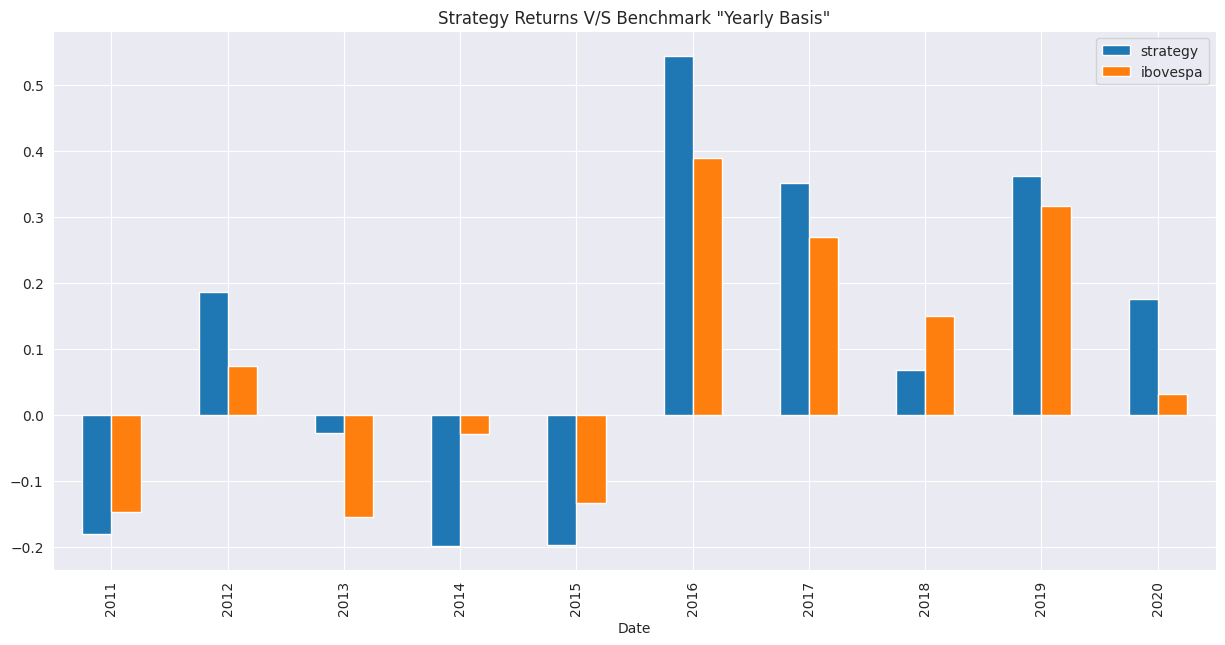

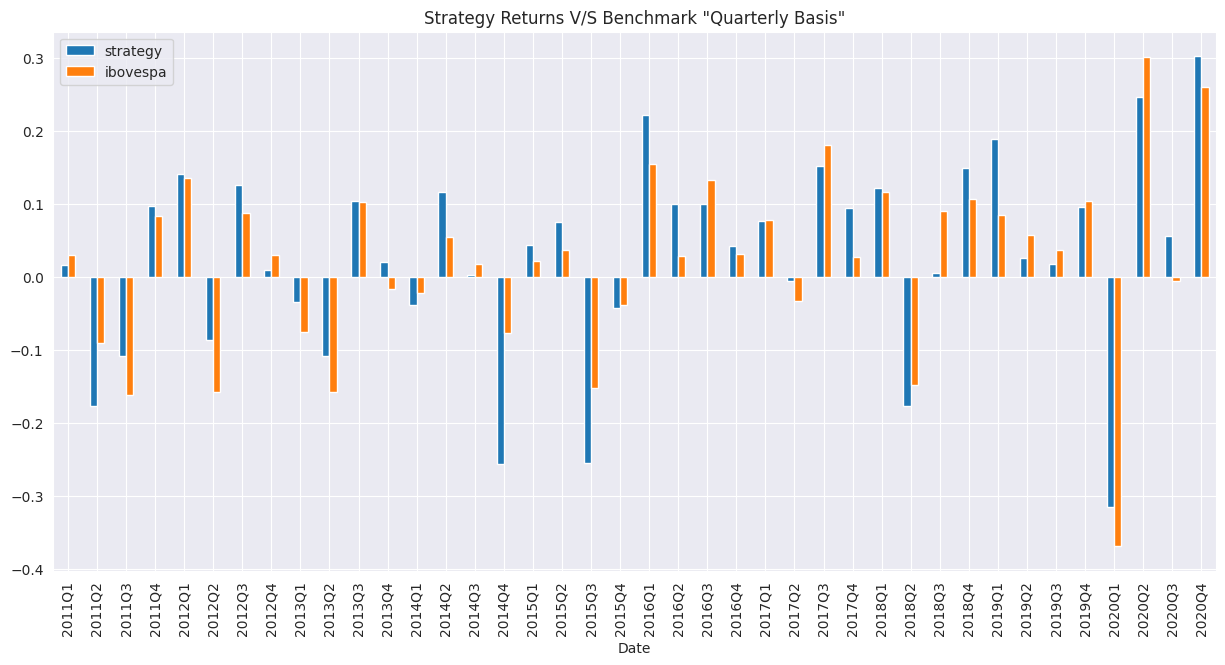

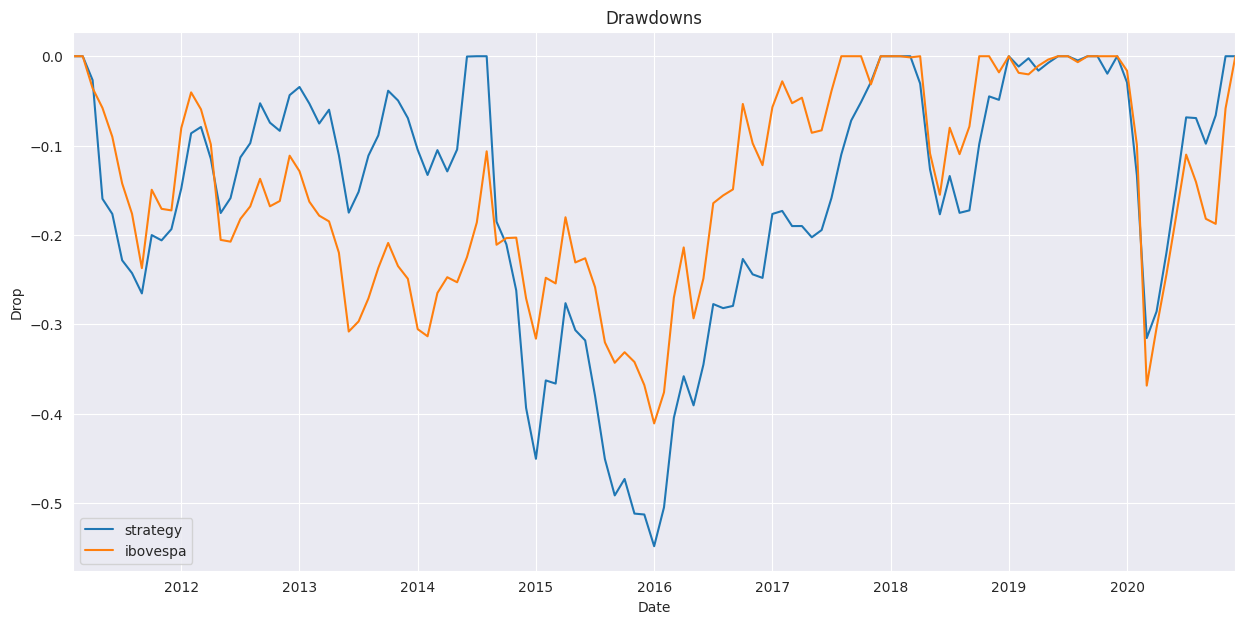

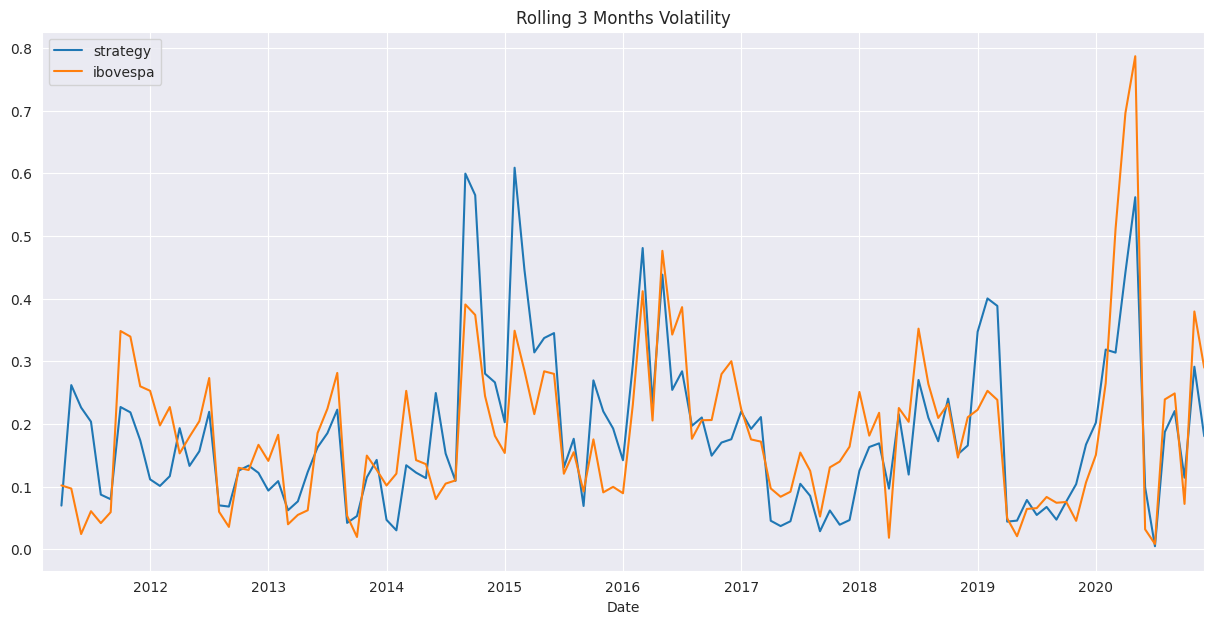

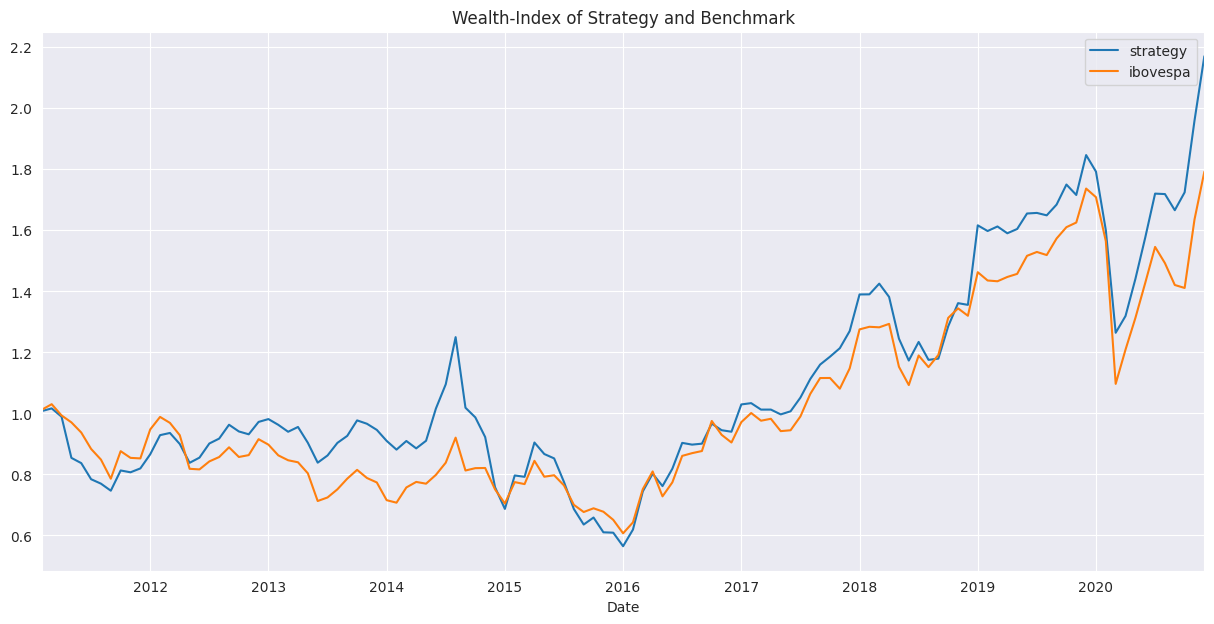

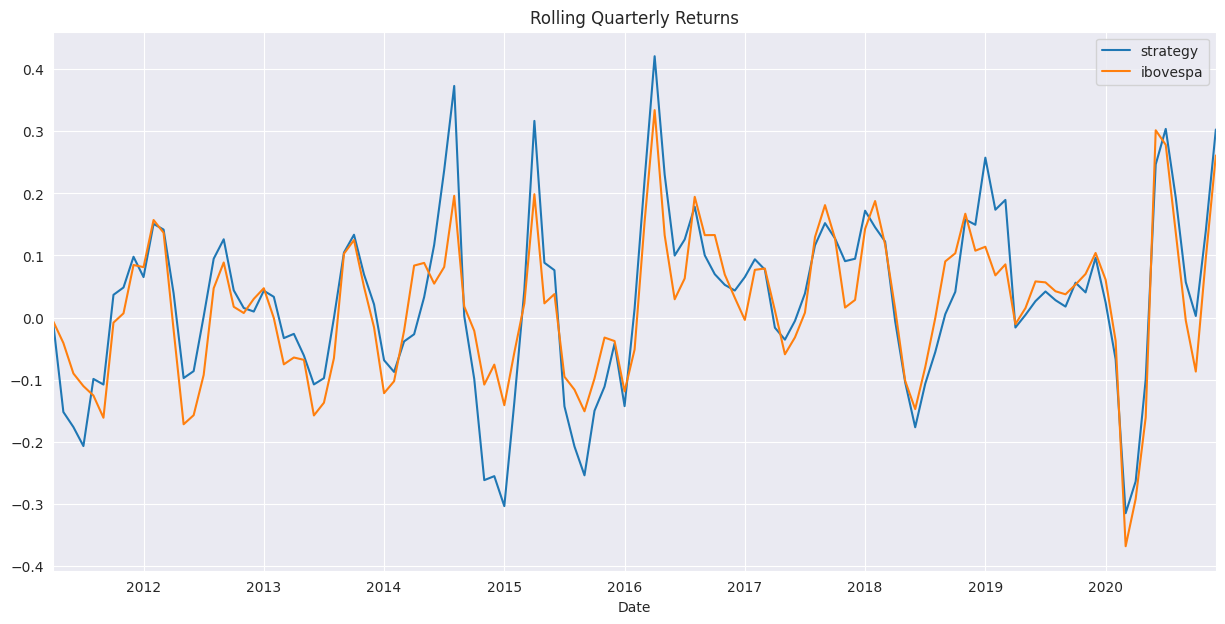

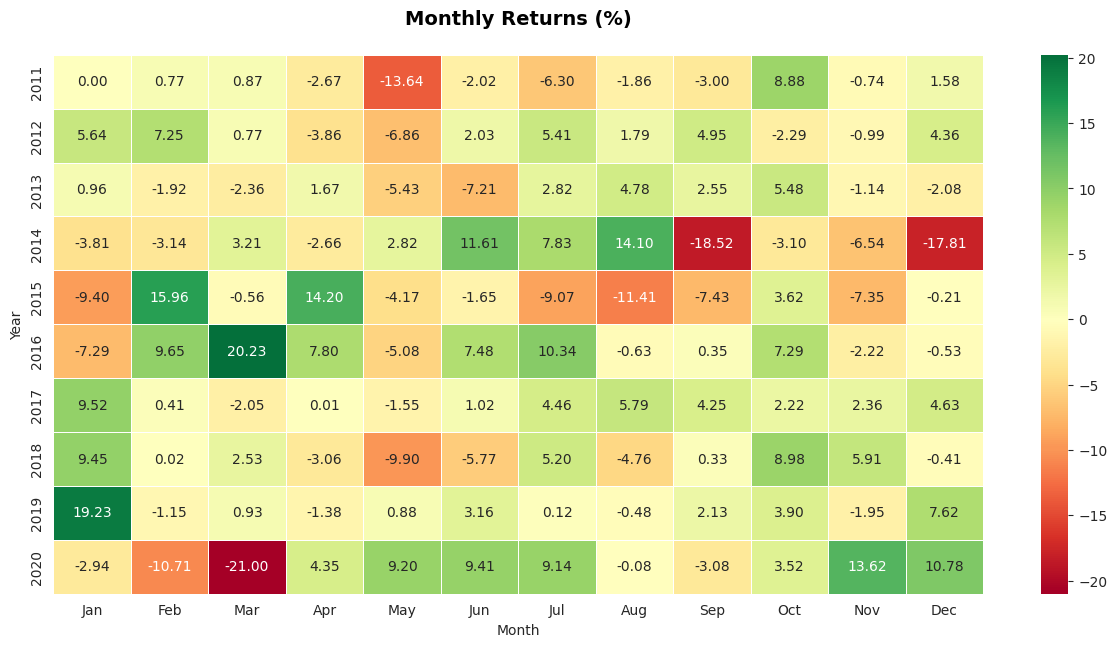

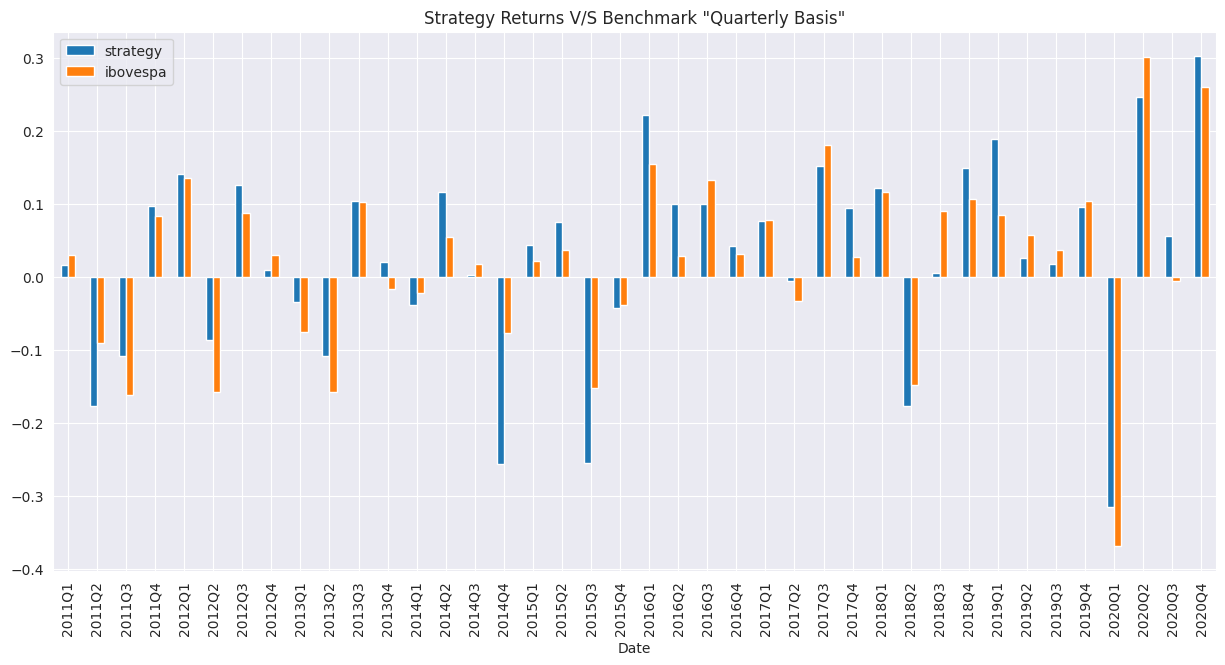

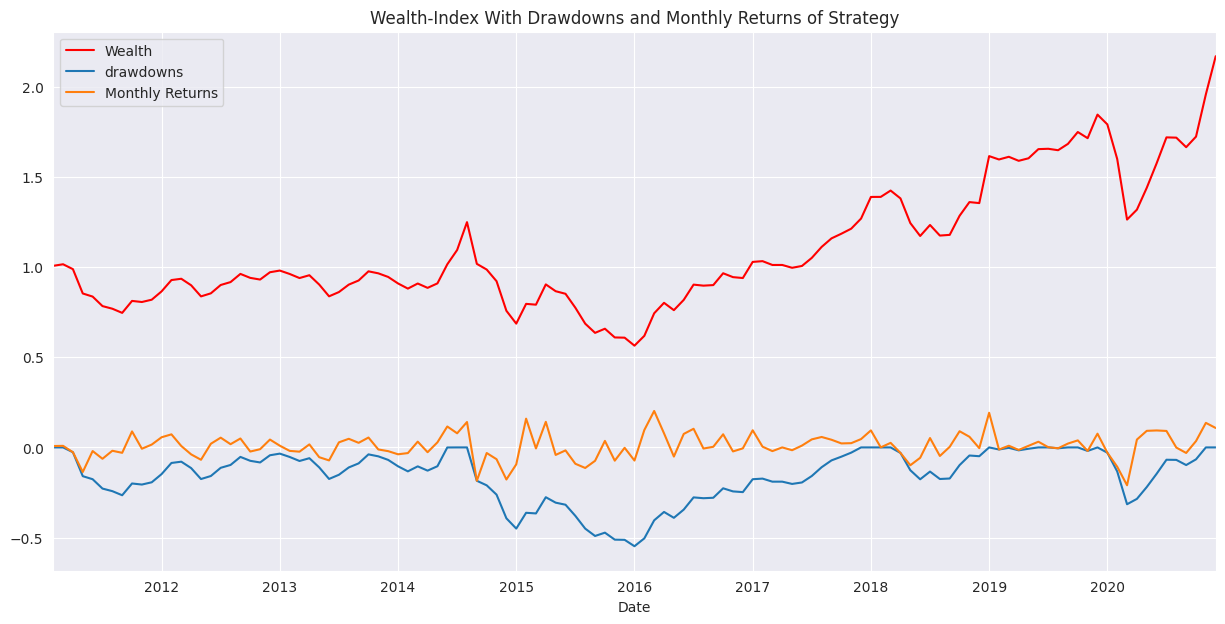

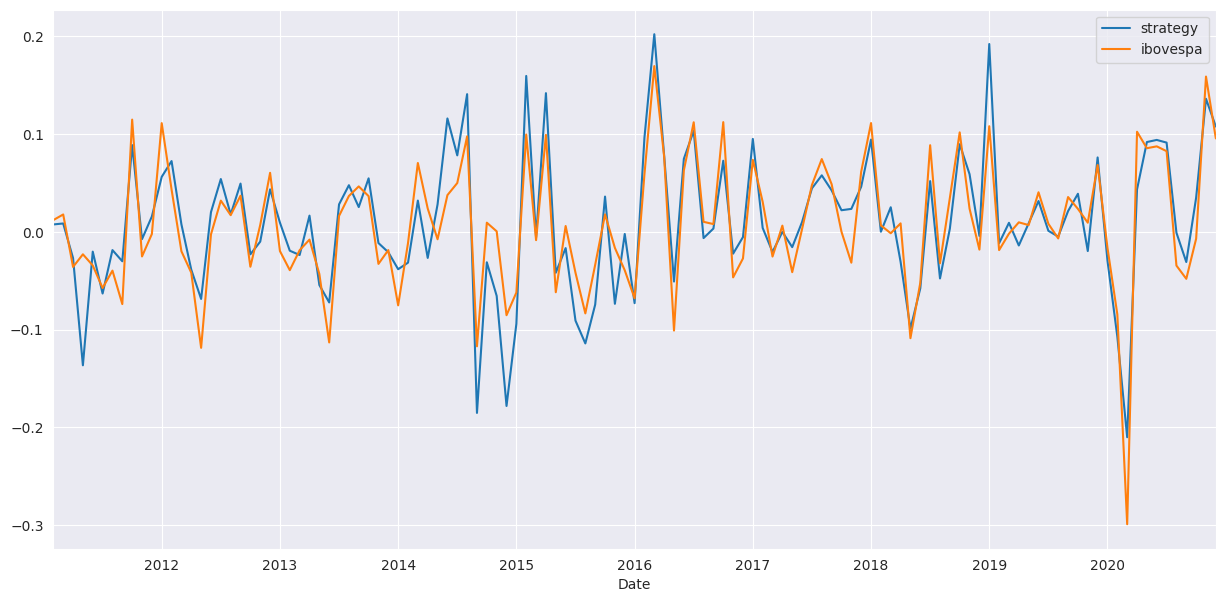

In [44]:
import tearsheet as ts
tear = ts.tear_sheet(frame_final, headline='Quantemantal Strategy para ações brasileiras')